In [1]:
# Code to start a Dask cluster with two workers and 1 thread each.
from graphviper.dask.client import local_client
viper_client = local_client(cores=4, memory_limit="4GB",autorestrictor=True)
# viper_client = local_client(serial_execution=True)
viper_client

[2024-07-16 11:14:49,439]     INFO  graphviper:  Checking parameter values for client.local_client 
[2024-07-16 11:14:49,440]     INFO  graphviper:  Module path: /remote/home/nakazato/miniforge3/envs/viper/lib/python3.11//site-packages/ 
[2024-07-16 11:14:49,453]  WARNING      client:  It is recommended that the local cache directory be set using the dask_local_dir parameter. 
[2024-07-16 11:14:51,810]     INFO      client:  Created client <MenrvaClient: 'tcp://127.0.0.1:38197' processes=4 threads=4, memory=14.90 GiB> 


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 14.90 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38197,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 14.90 GiB
Comm: tcp://127.0.0.1:38295,Total threads: 1
Dashboard: http://127.0.0.1:34169/status,Memory: 3.73 GiB
Nanny: tcp://127.0.0.1:35325,


In [2]:
import pandas as pd

pd.options.display.max_colwidth = 100
ps_store = "uid___A002_Xc1469f_X1c33.ms.zarr"

from xradio.vis.read_processing_set import read_processing_set

intents_on = ["OBSERVE_TARGET#ON_SOURCE"]
intents_off = ["OBSERVE_TARGET#OFF_SOURCE"]

fields = None

ps = read_processing_set(
    ps_store=ps_store,
    fields=fields,
)

In [3]:
# list of xds names corresponding to science target and science spw
ddi_list = [17, 19, 21, 23]
intent = intents_on[0]
science_xds_keys = [x for x in ps.keys() for ddi in ddi_list if x.startswith(f'uid___A002_Xc1469f_X1c33.ms.zarr_ddi_{ddi}_intent_{intent}_')]
science_xds_keys

['uid___A002_Xc1469f_X1c33.ms.zarr_ddi_17_intent_OBSERVE_TARGET#ON_SOURCE_field_id_2',
 'uid___A002_Xc1469f_X1c33.ms.zarr_ddi_17_intent_OBSERVE_TARGET#ON_SOURCE_field_id_4',
 'uid___A002_Xc1469f_X1c33.ms.zarr_ddi_19_intent_OBSERVE_TARGET#ON_SOURCE_field_id_2',
 'uid___A002_Xc1469f_X1c33.ms.zarr_ddi_19_intent_OBSERVE_TARGET#ON_SOURCE_field_id_4',
 'uid___A002_Xc1469f_X1c33.ms.zarr_ddi_21_intent_OBSERVE_TARGET#ON_SOURCE_field_id_2',
 'uid___A002_Xc1469f_X1c33.ms.zarr_ddi_21_intent_OBSERVE_TARGET#ON_SOURCE_field_id_4',
 'uid___A002_Xc1469f_X1c33.ms.zarr_ddi_23_intent_OBSERVE_TARGET#ON_SOURCE_field_id_2',
 'uid___A002_Xc1469f_X1c33.ms.zarr_ddi_23_intent_OBSERVE_TARGET#ON_SOURCE_field_id_4']

Text(0.5, 1.0, 'Averaged SPECTRUM before calibration')

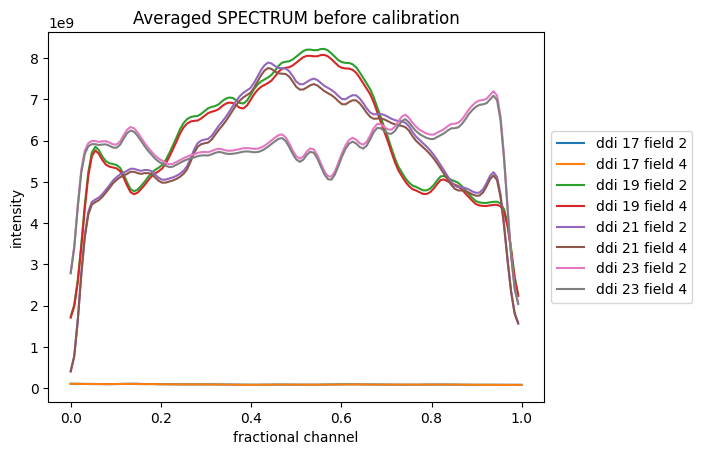

In [5]:
# visualize spectral data before calibration
import re

import matplotlib.pyplot as plt
import numpy as np

pattern = re.compile(r'.*_ddi_([0-9]+)_intent_.*_field_id_([0-9]+)$')

plt.clf()

for key in science_xds_keys:
    averaged = ps[key]['SPECTRUM'].mean(axis=(0, 1, 3)).compute()
    match = re.search(pattern, key)
    # print(match[1], match[2])
    ddi = int(match[1])
    field_id = int(match[2])
    x = np.arange(len(averaged)) / len(averaged)
    plt.plot(x, averaged, label=f'ddi {ddi} field {field_id}')

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0, 0.5, 1.0))
plt.xlabel('fractional channel')
plt.ylabel('intensity')
plt.title('Averaged SPECTRUM before calibration')

In [6]:
# list of functions to for sdcal prototype
def average_off_source_data(input_params: dict):
    import numpy as np
    
    from xradio.vis.load_processing_set import load_processing_set

    selection_off = dict((k, v) for k, v in input_params['data_selection'].items() if 'OBSERVE_TARGET#OFF_SOURCE' in k)
    
    ps = load_processing_set(
        ps_store=input_params['vis'],
        sel_parms=selection_off,
        data_variables=['SPECTRUM']
    )

    result = {}
    for xds_name, xds in ps.items():
        time = xds.time.data
        delta_time = time[1:] - time[:-1]
        median_time_gap = np.median(delta_time)
        time_gap = np.where(delta_time > median_time_gap * 5)[0]
        time_gap = np.concatenate([[0], time_gap, [len(time)]])
        print(f'{xds_name}: median time gap is {median_time_gap}, found time gap: {time_gap}')

        # TODO: should be a list of (time, averaged spectrum)
        average_off_spectra = np.array([
            xds['SPECTRUM'][s:e].mean(axis=0) for s, e in zip(time_gap[:-1], time_gap[1:])
        ])
        times_off = np.array([time[s:e].mean() for s, e in zip(time_gap[:-1], time_gap[1:])])

        field_id = int(xds_name.split('_field_id_')[1])
        result[xds_name] = {'field': field_id, 'time': times_off, 'spectra': average_off_spectra}

    # result = list(selection_off.keys())
    
    return result


def apply_position_switch_calibration(input_params: dict):
    import numpy as np
    from scipy.interpolate import interp1d
    
    from xradio.vis.load_processing_set import load_processing_set
    
    selection_on = dict((k, v) for k, v in input_params['data_selection'].items() if 'OBSERVE_TARGET#ON_SOURCE' in k)

    caltable = input_params['caltable']
    
    ps = load_processing_set(
        ps_store=input_params['vis'],
        sel_parms=selection_on,
        data_variables=['SPECTRUM']
    )

    result = {'data_selection': selection_on}

    field_mapping = input_params.get('field_mapping', None)

    for xds_name, xds in ps.items():
        if field_mapping:
            field_id_on = int(xds_name.split('_field_id_')[1])
            field_id_off = field_mapping[field_id_on]
            caltable_data = [x for x in caltable.values() if x['field_id'] == field_id_off][0]
        else:
            caltable_data = list(caltable.values())[0]

        # linear interpolation
        interpolator = interp1d(caltable_data['time'], caltable_data['spectra'], kind='linear', axis=0, fill_value='extrapolate', assume_sorted=True)

        time = xds.time.data
        spectra_off = interpolator(time)
        spectra_on = xds['SPECTRUM']
        calibrated = (spectra_on - spectra_off) / spectra_off
            

        result[xds_name] = calibrated
    
    return result


def sdcal_prototype(input_params: dict):
    # get caltable
    caltable = average_off_source_data(input_params)

    # apply caltable
    input_params['caltable'] = caltable
    calibrated = apply_position_switch_calibration(input_params)

    result = {'caltable': caltable, 'calibrated': calibrated, 'input_params': input_params}
    
    return result


def sdcal_reduce(graph_inputs, input_params):
    print('===REDUCE===')
    # print(graph_inputs)
    # print(input_params)

    import numpy as np
    from xradio.vis.read_processing_set import read_processing_set
    import dask

    ps = read_processing_set(ps_store=input_params['vis'])

    stitched_spectrum = {}
    for i in graph_inputs:
        calibrated = i['calibrated']
        data_selection = calibrated['data_selection']
        # sel = stitched_spectrum.setdefault('data_selection', [])
        # sel.append(data_selection)
        # params = stitched_spectrum.setdefault('input_params', [])
        # params.append(i['input_params'])
        for xds_name, sel in data_selection.items():
            result_spectrum = calibrated[xds_name]
            spectrum_shape = ps[xds_name]['SPECTRUM'].shape
            start = sel['frequency'].start
            end = sel['frequency'].stop
            print(f'processing {xds_name}')
            print(f'frequency slice: {start}~{end}')
            print(f'spectrum shape {spectrum_shape}, slice shape {result_spectrum.shape}')
            _tmp = stitched_spectrum.setdefault(xds_name, {})
            _result_spectrum = _tmp.setdefault('spectrum', np.zeros(spectrum_shape, dtype=float))
            _result_spectrum[:, :, start:end, :] = result_spectrum
            _slice_info = _tmp.setdefault('slice_info', [])
            _slice_info.append({})
            _slice_info[-1]['spectrum_shape'] = spectrum_shape
            _slice_info[-1]['channel_slice'] = (start, end)
            _slice_info[-1]['slice_shape'] = result_spectrum.shape
            print(f'xds {xds_name}')
            # print(f'Comparing {sel["frequency"]}: {dask.compute(result_spectrum.shape == input_spectrum_slice.shape and np.all(result_spectrum == input_spectrum_slice))}')
    return stitched_spectrum


In [9]:
# construct parallel coordinates per ddi
from IPython.display import HTML, display

from graphviper.utils.display import dict_to_html

def get_parallel_coords(ddi, ps, n_chunks=4):
    from graphviper.graph_tools.coordinate_utils import make_parallel_coord
    xds = [xds for xds in ps.values() if xds.ddi == ddi]
    
    parallel_coords = {}
    parallel_coords["frequency"] = make_parallel_coord(
        coord=xds[0].frequency, n_chunks=n_chunks
    )
    return parallel_coords
    

science_ddis = [17, 19, 21, 23]
parallel_coords = dict((ddi, get_parallel_coords(ddi, ps)) for ddi in science_ddis)
display(HTML(dict_to_html(parallel_coords)))

In [10]:
# create node-task mapping per ddi
from graphviper.graph_tools.coordinate_utils import (
    interpolate_data_coords_onto_parallel_coords,
)
from graphviper.utils.display import dict_to_html

from IPython.display import HTML, display

node_task_data_mapping = {}
for ddi, v in parallel_coords.items():
    ps_subset = dict((name, xds) for name, xds in ps.items() if xds.ddi == ddi)
    node_task_data_mapping[ddi] = interpolate_data_coords_onto_parallel_coords(v, ps_subset)

display(HTML(dict_to_html(node_task_data_mapping)))

In [11]:
# serialize node-task mapping
serial_index = 0
node2task = {}
for ddi, mapping_per_ddi in node_task_data_mapping.items():
    for chunk in mapping_per_ddi.values():
        tmp = chunk.copy()
        tmp['chunk_indices'] = tuple([serial_index])
        node2task[serial_index] = tmp
        serial_index += 1

display(HTML(dict_to_html(node2task)))

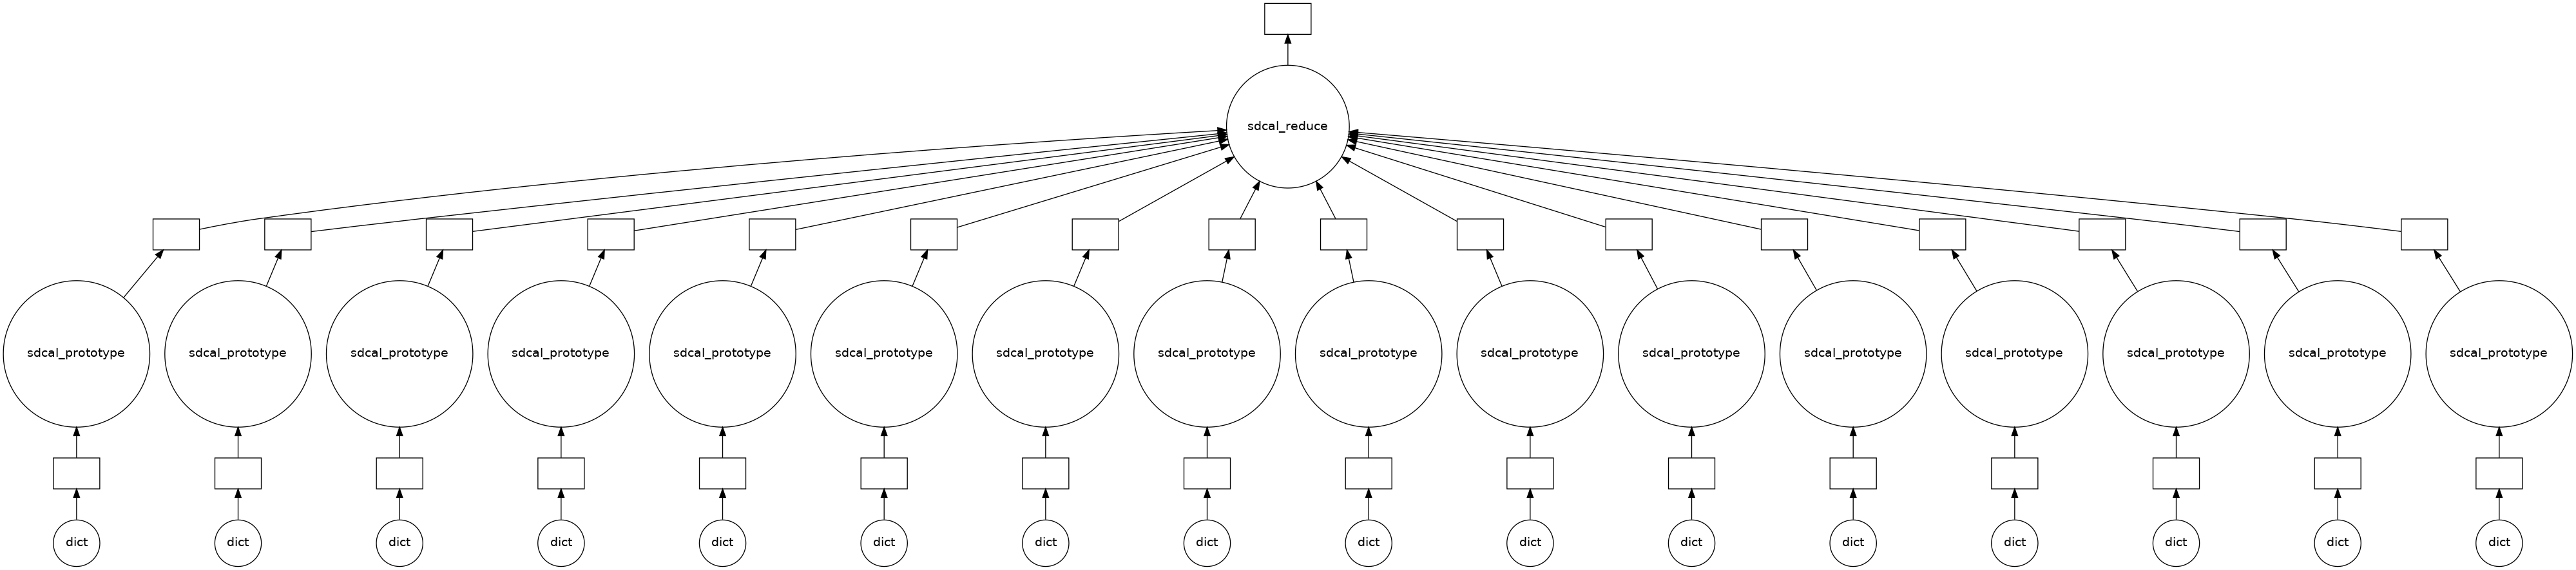

In [12]:
# construct dask graph using map and reduce
from graphviper.graph_tools.map import map
from graphviper.graph_tools.reduce import reduce
from graphviper.graph_tools.generate_dask_workflow import generate_dask_workflow

import dask

input_params = {}
input_params['vis'] = ps_store
viper_graph_map = map(input_data=ps, node_task_data_mapping=node2task, node_task=sdcal_prototype, input_params=input_params)

input_params = {}
input_params['vis'] = ps_store
# dictionary to map FIELD_ID_ON to FIELD_ID_OFF
input_params['field_mapping'] = {2: 1, 4: 3}
reduce_graph = reduce(
    graph=viper_graph_map,
    reduce_node_task=sdcal_reduce,
    input_params=input_params,
    mode='single_node'    
)

dask_graph = generate_dask_workflow(reduce_graph)

dask.visualize(dask_graph)

In [13]:
# run task
import time

start_time = time.time()
result = dask_graph.compute()
end_time = time.time()

print(f'\nElapsed {end_time - start_time} sec')

uid___A002_Xc1469f_X1c33.ms.zarr_ddi_17_intent_OBSERVE_TARGET#OFF_SOURCE_field_id_1: median time gap is 0.9760007858276367, found time gap: [  0  11  23  35  47  59  71  83  95 107 119 131 143 155 167 179 191 203
 215 227 239 251 263 275 287 299 311 323 335 347 359 371 383 396]
uid___A002_Xc1469f_X1c33.ms.zarr_ddi_17_intent_OBSERVE_TARGET#OFF_SOURCE_field_id_3: median time gap is 0.9760007858276367, found time gap: [  0  11  23  35  47  59  71  83  95 107 119 131 143 155 167 179 191 203
 215 227 239 251 263 275 287 299 311 323 335 347 359 371 383 396]
uid___A002_Xc1469f_X1c33.ms.zarr_ddi_19_intent_OBSERVE_TARGET#OFF_SOURCE_field_id_1: median time gap is 0.9760007858276367, found time gap: [  0  11  23  35  47  59  71  83  95 107 119 131 143 155 167 179 191 203
 215 227 239 251 263 275 287 299 311 323 335 347 359 371 383 396]
uid___A002_Xc1469f_X1c33.ms.zarr_ddi_19_intent_OBSERVE_TARGET#OFF_SOURCE_field_id_3: median time gap is 0.9760007858276367, found time gap: [  0  11  23  35  47  5

In [14]:
list(result.keys())

['uid___A002_Xc1469f_X1c33.ms.zarr_ddi_17_intent_OBSERVE_TARGET#ON_SOURCE_field_id_2',
 'uid___A002_Xc1469f_X1c33.ms.zarr_ddi_17_intent_OBSERVE_TARGET#ON_SOURCE_field_id_4',
 'uid___A002_Xc1469f_X1c33.ms.zarr_ddi_19_intent_OBSERVE_TARGET#ON_SOURCE_field_id_2',
 'uid___A002_Xc1469f_X1c33.ms.zarr_ddi_19_intent_OBSERVE_TARGET#ON_SOURCE_field_id_4',
 'uid___A002_Xc1469f_X1c33.ms.zarr_ddi_21_intent_OBSERVE_TARGET#ON_SOURCE_field_id_2',
 'uid___A002_Xc1469f_X1c33.ms.zarr_ddi_21_intent_OBSERVE_TARGET#ON_SOURCE_field_id_4',
 'uid___A002_Xc1469f_X1c33.ms.zarr_ddi_23_intent_OBSERVE_TARGET#ON_SOURCE_field_id_2',
 'uid___A002_Xc1469f_X1c33.ms.zarr_ddi_23_intent_OBSERVE_TARGET#ON_SOURCE_field_id_4']

Text(0.5, 1.0, 'Averaged SPECTRUM after calibration')

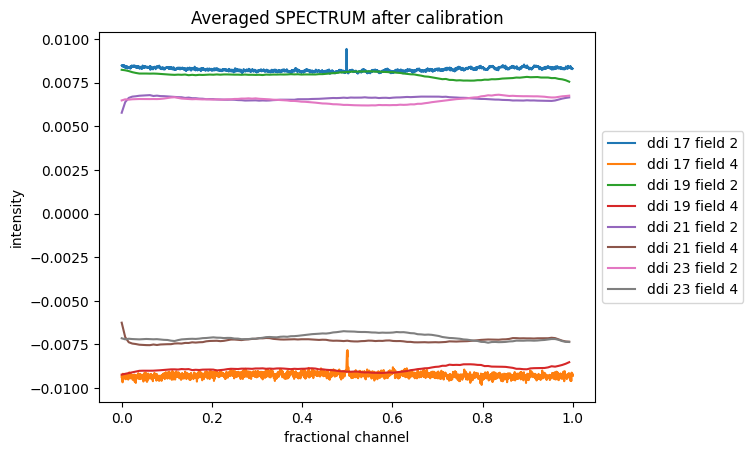

In [15]:
# visualize spectral data after calibration
import matplotlib.pyplot as plt
import numpy as np

pattern = re.compile(r'.*_ddi_([0-9]+)_intent_.*_field_id_([0-9]+)$')

plt.clf()

for xds, result_subset in result.items():
    match = re.search(pattern, xds)
    ddi = int(match[1])
    field_id = int(match[2])
    sp = result_subset['spectrum']
    asp = sp.mean(axis=(0, 1, 3))
    nchan = len(asp)
    x = np.arange(nchan) / nchan
    plt.plot(x, asp, label=f'ddi {ddi} field {field_id}')

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0, 0.5, 1.0))
plt.xlabel('fractional channel')
plt.ylabel('intensity')
plt.title('Averaged SPECTRUM after calibration')